# Thematic differences (Hungary)

DHH23 Parliament group

Author: Pontus H.

In [112]:
# Set the theme here
THEME = 'healthcare_HU'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'
# Set the output path for the model
MODEL_PATH = '../data/models/'

In [113]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd

In [114]:
# Hungarian stopwords
with open('../data/stopwords-hu.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

Set up the BERTopic pipeline

In [115]:
df = pd.read_csv(f'../data/{THEME}.csv')
import numpy as np


In [116]:
# Parameters
# PARAMETERS FOR EU: MIN_CLUSTER_SIZE = 50, MIN_SAMPLES = 1, CLUSTER_SELECTION_EPSILON = 0.1
# PARAMETERS FOR WAR: MIN_CLUSTER_SIZE = 20, MIN_SAMPLES = 1, CLUSTER_SELECTION_EPSILON = 0.05
# PARAMETERS FOR HEALTHCARE: MIN_CLUSTER_SIZE = 20, MIN_SAMPLES = 1, CLUSTER_SELECTION_EPSILON = 0.05
HDBSCAN_MIN_CLUSTER_SIZE = int(np.sqrt(len(df)))
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0
OUTLIER_THRESHOLD = 0.1

# Step 1 - Extract embeddings
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # English
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2') # Other languages

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=10, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
# vectorizer_model = CountVectorizer(stop_words="english") # English
vectorizer_model = CountVectorizer(stop_words=stopwords) # Other languages

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  #nr_topics="25",
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [117]:
df['Speaker_party'].describe()

count             4530
unique              19
top       KNDP-frakció
freq              1026
Name: Speaker_party, dtype: object

In [118]:
# Reference running time for this cell: 4min 00s
topics, probs = topic_model.fit_transform(df['speech'])


In [119]:
# Reduce outliers
# threshold was decreased from 0.1 to 0.05 for gender_HU
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=OUTLIER_THRESHOLD)


In [120]:
pd.Series(new_topics).value_counts()

 0     872
 1     668
 2     626
-1     621
 3     498
 4     379
 5     228
 7     209
 6     169
 8     128
 9     110
 10     75
dtype: int64

In [121]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [122]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [123]:
# Number of topics
print(f"Number of topics: {len(pd.Series(new_topics).unique())}")

Number of topics: 12


In [124]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

-1     1354
 8      718
 6      519
 10     481
 4      460
 7      292
 5      165
 9      159
 3      151
 1      120
 2       91
 0       73
dtype: int64

In [125]:
topic_model.visualize_topics()

What is interesting about the plot above is that the keywords associated with the topic CHANGE over time! Maybe this could be a useful pointer towards further exploration.

In [126]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
# Create the output directory if it does not exist
import os
if not os.path.exists(f"{OUTPUT_PATH}{THEME}"):
    os.makedirs(f"{OUTPUT_PATH}{THEME}")
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}/{THEME}_topic_keywords.png")
topic_word_scores

# Word Clouds

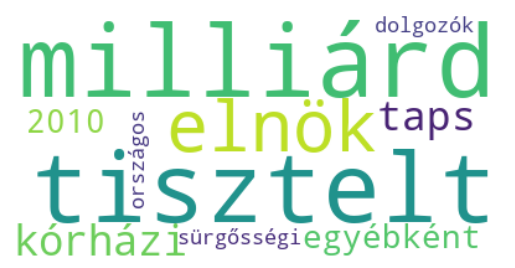

In [127]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

In [128]:
# topic_model.visualize_heatmap(n_clusters=5, top_n_topics=10)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [129]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
# get_keywords(0)

In [130]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Drop speeches with no party
speech_topic_party = speech_topic_party.dropna()
# Set the party name to 'Fidesz-KDNP' if the name contains Fidesz-frakció,  KNDP-frakció or Fidesz
speech_topic_party.loc[speech_topic_party['party'].str.contains('Fidesz-frakció|KNDP-frakció|Fidesz'), 'party'] = 'Fidesz-KDNP'
# Set the party name to 'Opposition' if the name contains MSZP or MSZP-frakció
speech_topic_party.loc[speech_topic_party['party'].str.contains('MSZP|MSZP-frakció'), 'party'] = 'Opposition'
# Set the party name to 'OTHER' if the party name does not contain 'Fidesz-KDNP' or 'Opposition'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('Fidesz-KDNP|Opposition'), 'party'] = 'OTHER'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
#speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

party,Fidesz-KDNP,OTHER,Opposition
topic,,,
0,363,324,183
1,412,187,60
2,203,273,138
3,180,236,68
4,225,100,53
5,92,99,32
6,79,68,20
7,53,100,54
8,47,69,11


In [131]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,Fidesz-KDNP,OTHER,Opposition
topic,,,
0,21.4,21.4,29.1
1,24.3,12.4,9.5
2,12.0,18.0,21.9
3,10.6,15.6,10.8
4,13.3,6.6,8.4
5,5.4,6.5,5.1
6,4.7,4.5,3.2
7,3.1,6.6,8.6
8,2.8,4.6,1.7


In [132]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
# percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,Fidesz-KDNP,OTHER,Opposition,keywords
topic,,,,
0,21.4,21.4,29.1,"[milliárd, tisztelt, elnök, kórházi, taps, egy..."
1,24.3,12.4,9.5,"[koronavírus, védekezés, magyarország, egészsé..."
2,12.0,18.0,21.9,"[törvény, magyar, tisztelt, szeretném, emberek..."
3,10.6,15.6,10.8,"[európai, magyarország, emberek, miniszterelnö..."
4,13.3,6.6,8.4,"[tisztelt, milliárd, magyarországon, jobbik, e..."
5,5.4,6.5,5.1,"[költségvetés, tisztelt, jövő, magyarország, s..."
6,4.7,4.5,3.2,"[tisztelt, elnök, dr, soraiban, taps, kormányp..."
7,3.1,6.6,8.6,"[kormány, költségvetésben, magyar, 2017, gondo..."
8,2.8,4.6,1.7,"[önkormányzat, élők, tisztelt, elnök, fejleszt..."


In [133]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
# percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,Fidesz-KDNP,OTHER,Opposition
0,0,41.7,37.2,21.0
1,1,62.5,28.4,9.1
2,2,33.1,44.5,22.5
3,3,37.2,48.8,14.0
4,4,59.5,26.5,14.0
5,5,41.3,44.4,14.3
6,6,47.3,40.7,12.0
7,7,25.6,48.3,26.1
8,8,37.0,54.3,8.7
9,9,38.2,52.7,9.1


Calculate mean sentiment for each topic per party

In [134]:
# sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment']})
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'speech_id': df['ID'], 'party': df['Speaker_party'], 'speaker_party': df['Speaker_party'], 'sentiment': df['sentiment'], 'speech_date': df['Date'], 'prob': list(probs), 'speech': df['speech']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Drop speeches with no party
sentiment_topic_party = sentiment_topic_party.dropna()
# Set the party name to 'Fidesz-KDNP' if the name contains Fidesz-frakció,  KNDP-frakció or Fidesz
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('Fidesz-frakció|KNDP-frakció|Fidesz'), 'party'] = 'Fidesz-KDNP'
# Set the party name to 'Opposition' if the name contains MSZP or MSZP-frakció
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('MSZP|MSZP-frakció'), 'party'] = 'Opposition'
# Set the party name to 'OTHER' if the party name does not contain 'Fidesz-KDNP' or 'Opposition'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('Fidesz-KDNP|Opposition'), 'party'] = 'OTHER'
# Create a new dataframe with the relevant speeches and remove
relevant_speeches = sentiment_topic_party.copy()
sentiment_topic_party.drop(columns=['speech', 'speech_date', 'prob'], inplace=True)
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
# sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,Fidesz-KDNP,OTHER,Opposition
topic,,,
0,-0.17,-0.53,-0.59
1,-0.13,-0.40,-0.52
2,-0.26,-0.41,-0.44
3,-0.19,-0.52,-0.52
4,-0.41,-0.61,-0.58
5,-0.03,-0.47,-0.48
6,-0.60,-0.60,-0.47
7,-0.00,-0.46,-0.55
8,0.20,-0.43,-0.31


In [135]:
# Save the topic model
topic_model.save(f"{MODEL_PATH}{THEME}_topic_model.bin")

In [136]:
def get_top_3(topic_id, party_name):
    speeches_for_topic_0_con = relevant_speeches[(relevant_speeches['party'] == party_name) & (relevant_speeches['topic'] == topic_id)]
    speeches_for_topic_0_con['prob'] = speeches_for_topic_0_con['prob'].apply(lambda x: x[topic_id])
    speeches_for_topic_0_con = speeches_for_topic_0_con.sort_values(by='sentiment', ascending=False)
    most_positive = speeches_for_topic_0_con.head(3)
    most_negative = speeches_for_topic_0_con.tail(3)
    return most_positive.append(most_negative).drop_duplicates(subset=['speech_id'])

parties = ['Fidesz-KDNP', 'Opposition', 'OTHER']

max_topic = relevant_speeches['topic'].max()

representative_speeches = get_top_3(0, 'Fidesz-KDNP')
for party in parties[1:]:
    representative_speeches = representative_speeches.append(get_top_3(0, party))
for topic_id in range(1,max_topic+1):
    for party in parties:
        representative_speeches = representative_speeches.append(get_top_3(topic_id, party))

# Save the representative speeches to a csv and feather file. Use '"" as the quotechar to avoid issues with the speech text
representative_speeches.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_representative_speeches.csv', quotechar='"', index=False)
representative_speeches.reset_index().to_feather(f'{OUTPUT_PATH}{THEME}/{THEME}_representative_speeches.feather')
representative_speeches

,topic,speech_id,party,speaker_party,sentiment,speech_date,prob,speech
3726,0,u2016-12-05-137,Fidesz-KDNP,KNDP-frakció,0.964844,2016-12-05,0.180005,"Köszönöm a válaszát, államtitkár úr. Azt gondo..."
1190,0,u2015-03-31-19,Fidesz-KDNP,KNDP-frakció,0.869629,2015-03-31,0.086406,Köszönöm szépen a szót. Tisztelt Elnök Úr! Tis...
1038,0,u2021-02-22-95,Fidesz-KDNP,KNDP-frakció,0.791504,2021-02-22,0.050462,"Köszönöm szépen a szót, elnök úr. Tisztelt Kép..."
2472,0,u2020-11-16-77,Fidesz-KDNP,Fidesz-frakció,-1.000000,2020-11-16,0.188261,"Látom, hogy dühös ránk [[Derültség a kormánypá..."
3204,0,u2016-09-26-193,Fidesz-KDNP,KNDP-frakció,-1.000000,2016-09-26,0.164446,"Köszönöm szépen a szót, elnök úr. Tisztelt Kép..."
...,...,...,...,...,...,...,...,...
2824,9,u2020-04-21-257,OTHER,DK-frakció,0.507324,2020-04-21,0.993603,"Köszönöm a szót, elnök úr. Tisztelt Ház! Tiszt..."
2971,9,u2014-09-24-283,OTHER,LMP-frakció,0.420654,2014-09-24,0.230898,Köszönöm szépen. Tisztelt Elnök Úr! Tisztelt K...
4082,9,u2018-10-08-41,OTHER,LMP-frakció,-0.970215,2018-10-08,0.994890,"Köszönöm a szót, elnök úr. Tisztelt Államtitká..."
1122,9,u2022-06-14-1,OTHER,LMP-frakció,-0.989746,2022-06-14,0.995081,"Köszönöm a szót, elnök úr. Tisztelt Ház! Jelen..."


In [137]:
# Create a new dataframe from percentages, percentages_per_row and sentiment_topic_party
concatenated_results = pd.concat([percentages, percentages_per_row, sentiment_topic_party], axis=1)
# Rename the columns to make it easier to understand
concatenated_results.columns = ['pf.Fidesz-KDNP', 'pf.OTHER', 'pf.Opposition', 'keywords', 'tc.Fidesz-KDNP', 'tc.OTHER', 'tc.Opposition', 's.Fidesz-KDNP', 's.OTHER', 's.Opposition']
# Reorder the columns
concatenated_results = concatenated_results[['keywords', 'tc.Fidesz-KDNP', 'tc.Opposition', 'tc.OTHER', 'pf.Fidesz-KDNP', 'pf.Opposition', 'pf.OTHER', 's.Fidesz-KDNP', 's.Opposition', 's.OTHER']]
# Save the results to a csv
concatenated_results.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_results.csv')
concatenated_results

,keywords,tc.Fidesz-KDNP,tc.Opposition,tc.OTHER,pf.Fidesz-KDNP,pf.Opposition,pf.OTHER,s.Fidesz-KDNP,s.Opposition,s.OTHER
topic,,,,,,,,,,
0,"[milliárd, tisztelt, elnök, kórházi, taps, egy...",41.7,21.0,37.2,21.4,29.1,21.4,-0.17,-0.59,-0.53
1,"[koronavírus, védekezés, magyarország, egészsé...",62.5,9.1,28.4,24.3,9.5,12.4,-0.13,-0.52,-0.40
2,"[törvény, magyar, tisztelt, szeretném, emberek...",33.1,22.5,44.5,12.0,21.9,18.0,-0.26,-0.44,-0.41
3,"[európai, magyarország, emberek, miniszterelnö...",37.2,14.0,48.8,10.6,10.8,15.6,-0.19,-0.52,-0.52
4,"[tisztelt, milliárd, magyarországon, jobbik, e...",59.5,14.0,26.5,13.3,8.4,6.6,-0.41,-0.58,-0.61
5,"[költségvetés, tisztelt, jövő, magyarország, s...",41.3,14.3,44.4,5.4,5.1,6.5,-0.03,-0.48,-0.47
6,"[tisztelt, elnök, dr, soraiban, taps, kormányp...",47.3,12.0,40.7,4.7,3.2,4.5,-0.60,-0.47,-0.60
7,"[kormány, költségvetésben, magyar, 2017, gondo...",25.6,26.1,48.3,3.1,8.6,6.6,-0.00,-0.55,-0.46
8,"[önkormányzat, élők, tisztelt, elnök, fejleszt...",37.0,8.7,54.3,2.8,1.7,4.6,0.20,-0.31,-0.43
